<a href="https://colab.research.google.com/github/hscrown/madatpublicdata/blob/main/collaborative_filtering_%EC%97%B0%EC%8A%B5(6)_%EC%9E%A0%EC%9E%AC%EC%9A%94%EC%9D%B8%EA%B8%B0%EB%B0%98_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

잠재요인기반 협업 필터링  

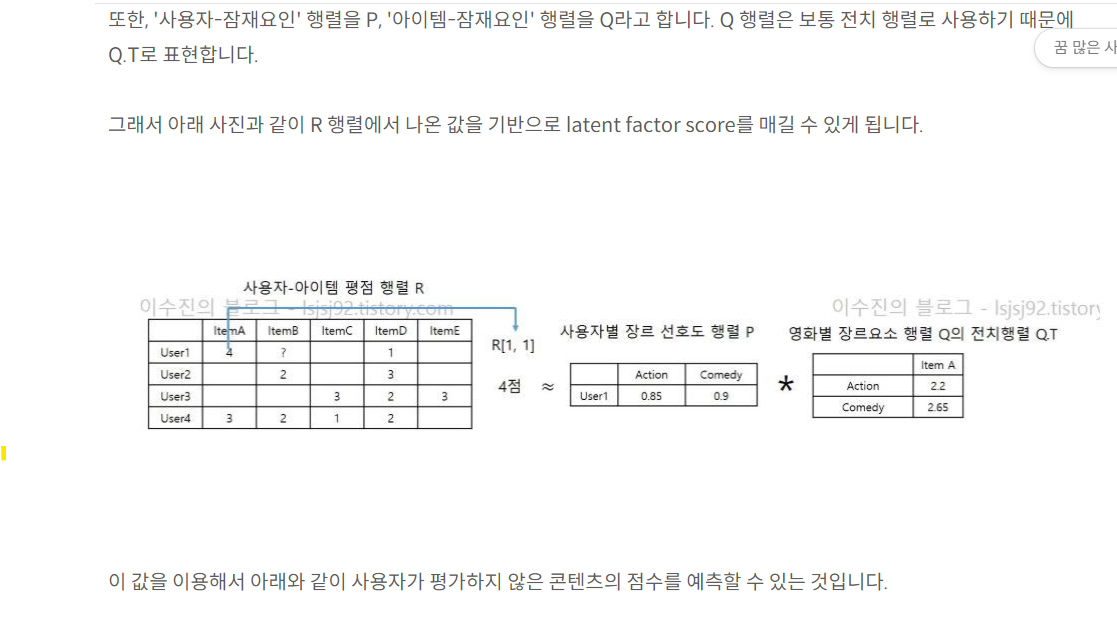

In [14]:
!pip install datasets

from sklearn.decomposition import TruncatedSVD
from scipy.sparse.linalg import svds

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from datasets import load_dataset

## 데이터로드 및 전처리

도서관데이터

In [15]:
# 필요한 컬럼 # 시설명, 구이름, 장소구분
lib = pd.read_csv('seoul_libs.csv', encoding='utf-8')
lib.head()

# 밸류값이 모두 'lib'인 ['type'] 칼럼 추가
lib['type'] = 'lib'

# 컬럼명 변경
cols= {'도서관 일련번호':'place_id', '도서관명':'place_name', '구명':'gu_name'}
lib = lib.rename(columns=cols)
lib.columns

# # 필요한 컬럼만 추출
lib=lib[['place_name', 'gu_name', 'type']]
lib.head()


,place_name,gu_name,type
0,BIBLIOTECA,강남구,lib
1,LH강남3단지작은도서관,강남구,lib
2,休+밤토리SH작은도서관,강남구,lib
3,강남구립못골도서관,강남구,lib
4,강남데시앙파크작은도서관,강남구,lib


공원데이터

In [16]:
# 필요한 컬럼 # 시설명, 구이름, 장소구분
par = pd.read_csv('seoul_parks.csv', encoding='utf-8')
par.head()
par.columns
# 밸류값이 모두 'par'인 ['type'] 칼럼 추가
par['type'] = 'par'

# 컬럼명 변경
cols= {'공원명':'place_name', '공원주소':'gu_name'}
par = par.rename(columns=cols)
par.columns

# 공원주소 컬럼에서 구 이름만 추출
par['gu_name'] = par['gu_name'].str.split(' ', expand=True)[1]

# 결측치 삭제
par = par.dropna()

# gu_name이 '구'로 끝나지 않으면 삭제
par = par[par['gu_name'].str.endswith('구')]

# # 필요한 컬럼만 추출
par=par[['place_name', 'gu_name', 'type']]
par.head()

,place_name,gu_name,type
0,남산도시자연공원,중구,par
12,여의도근린공원,영등포구,par
16,보라매근린공원,동작구,par
17,어린이대공원,광진구,par
18,천호근린공원,강동구,par


박물관, 미술관 데이터

In [11]:
dataset = load_dataset("hscrown/seoul_museums")
muse = pd.DataFrame(dataset['train'])

muse.columns

# 밸류값이 모두 'muse'인 ['type'] 칼럼 추가
muse['type'] = 'muse'

# 컬럼명 변경
cols= {'시설명':'place_name', '주소':'gu_name'}
muse = muse.rename(columns=cols)

# 주소 컬럼에서 구 이름만 추출
muse['gu_name'] = muse['gu_name'].str.split(' ', expand=True)[1]

# gu_name이 '구'로 끝나지 않으면 삭제
muse = muse[muse['gu_name'].str.endswith('구')]
# # 필요한 컬럼만 추출
muse=muse[['place_name', 'gu_name', 'type']]

muse.tail()

Repo card metadata block was not found. Setting CardData to empty.


,place_name,gu_name,type
170,매헌윤봉길의사기념관,서초구,muse
171,동덕여자대학교 박물관,성북구,muse
172,DDP디자인뮤지엄,중구,muse
173,아모레퍼시픽미술관,용산구,muse
174,롯데뮤지엄,송파구,muse


In [12]:
# 공원데이터와 도서관 데이터 합침
df = pd.concat([lib, par,muse])
df.tail()

# 인덱스 초기화
df = df.reset_index(drop=True)

# 'place_id' 컬럼 만들고 인덱스 밸류로 넣기
df['place_id'] = df.index

df.head()

# df 를 csv 파일로 변환
df.to_csv('places.csv', index=False, encoding='utf-8')

In [13]:
df.tail()

,place_name,gu_name,type,place_id
1658,매헌윤봉길의사기념관,서초구,muse,1658
1659,동덕여자대학교 박물관,성북구,muse,1659
1660,DDP디자인뮤지엄,중구,muse,1660
1661,아모레퍼시픽미술관,용산구,muse,1661
1662,롯데뮤지엄,송파구,muse,1662


# 사용자 평점데이터 만들기

In [17]:
import pandas as pd
import numpy as np

def generate_user_ratings(num_users):
    # df가 이미 정의되어 있다고 가정해. 없으면 먼저 정의해야 돼.
    users = [df.copy() for _ in range(num_users)]

    # 'place_name' 열은 필요 없고, 열 이름을 바꾸자
    for user_id, user_df in enumerate(users):
        user_df.drop(columns='place_name', inplace=True)
        user_df.columns = ['user_id', 'rating','place_id']
        user_df['user_id'] = user_id

    # 사용자 데이터프레임을 합치자
    user_rating = pd.concat(users)

    # 'rating' 열의 NaN 값을 0으로 채워
    user_rating['rating'] = user_rating['rating'].fillna(0)

    # 평점을 평균이 3.5이고 표준 편차가 1.5인 분포로 나오게해서 정규분포와 비슷하면서 0값이 나오게함.
    ratings_mean = 3.5
    ratings_std = 1.5
    raw_ratings = np.random.normal(ratings_mean, ratings_std, size=len(user_rating))

    # 평점을 가장 가까운 0.5로 반올림해
    rounded_ratings = np.round(raw_ratings * 2) / 2

    # 평점을 0과 5 사이로 맞춰
    rounded_ratings = np.clip(rounded_ratings, 0, 5)

    user_rating['rating'] = rounded_ratings

    # 각 사용자의 평균 평점을 계산합니다.
    user_means = user_rating.groupby('user_id')['rating'].mean()

    # 각 사용자의 평균 평점을 중심으로 노이즈를 추가합니다.
    for user_id, mean_rating in user_means.items():
        # 해당 사용자의 데이터 인덱스를 가져옵니다.
        user_indices = user_rating['user_id'] == user_id
        # 평균 평점을 중심으로 표준 정규 분포에서 샘플링하여 노이즈를 추가합니다.
        noise = np.random.normal(loc=0, scale=1, size=np.sum(user_indices))
        # 원래의 평점에 노이즈를 더합니다.
        user_rating.loc[user_indices, 'rating'] += noise

    # 평점을 0과 5 사이로 맞춥니다.
    user_rating['rating'] = user_rating['rating'].clip(0, 5)

    # 평점을 가장 가까운 0.5로 반올림해
    rounded_ratings = np.round(user_rating['rating'] * 2) / 2

    # 소수점 1의 자리에서 잘라
    rounded_ratings = np.clip(rounded_ratings, 0, 5)

    user_rating['rating'] = rounded_ratings

    return user_rating

# 사용자 수를 바꿔서 테스트해봐
num_users = 1000
user_rating = generate_user_ratings(num_users)
user_rating.tail()


,user_id,rating,place_id
1658,999,5.0,1658
1659,999,0.0,1659
1660,999,2.0,1660
1661,999,4.0,1661
1662,999,3.5,1662


In [18]:
user_rating.to_csv(f'user_rating_{num_users}.csv', index=False, encoding='utf-8')

아이템-특성 데이터 만들기

In [19]:
# place_id, type, place_name만 추출
item_feature = df[['place_id', 'type', 'place_name']]
item_feature.head()

,place_id,type,place_name
0,0,lib,BIBLIOTECA
1,1,lib,LH강남3단지작은도서관
2,2,lib,休+밤토리SH작은도서관
3,3,lib,강남구립못골도서관
4,4,lib,강남데시앙파크작은도서관


# 추천시스템구현

데이터확인

In [20]:
# 사용자-장소 평점기반데이터
user_rating.shape  # (4989, 3)

(1663000, 3)

In [21]:
# 장소 정보 데이터
item_feature = item_feature[['place_id','place_name']]
item_feature

,place_id,place_name
0,0,BIBLIOTECA
1,1,LH강남3단지작은도서관
2,2,休+밤토리SH작은도서관
3,3,강남구립못골도서관
4,4,강남데시앙파크작은도서관
...,...,...
1658,1658,매헌윤봉길의사기념관
1659,1659,동덕여자대학교 박물관
1660,1660,DDP디자인뮤지엄
1661,1661,아모레퍼시픽미술관


In [22]:
user_place_data = pd.merge(user_rating, item_feature, on='place_id')
user_place_data.head()

,user_id,rating,place_id,place_name
0,0,5.0,0,BIBLIOTECA
1,1,3.5,0,BIBLIOTECA
2,2,3.5,0,BIBLIOTECA
3,3,5.0,0,BIBLIOTECA
4,4,5.0,0,BIBLIOTECA


In [23]:
user_place_data.shape # (4989, 4)

(1663000, 4)

In [24]:
# 사용자-평점데이터로 변경
df_user_place_ratings = user_place_data.pivot_table(index='user_id', columns='place_id', values='rating')
df_user_place_ratings.head()

place_id,0,1,2,3,4,5,6,7,8,9,...,1653,1654,1655,1656,1657,1658,1659,1660,1661,1662
user_id,,,,,,,,,,,,,,,,,,,,,
0,5.0,1.5,3.0,4.5,1.5,0.0,1.5,2.0,2.0,2.5,...,0.5,3.0,5.0,2.5,0.0,5.0,3.0,4.0,4.5,2.5
1,3.5,2.0,4.5,2.5,4.0,1.5,2.0,2.5,5.0,2.5,...,3.5,1.5,3.0,3.5,2.0,3.5,5.0,3.5,1.0,3.5
2,3.5,1.0,4.0,2.0,4.5,5.0,3.5,2.5,3.0,5.0,...,1.5,0.5,5.0,2.0,2.0,0.5,5.0,5.0,5.0,5.0
3,5.0,5.0,2.0,4.5,1.5,5.0,3.5,1.5,2.0,1.0,...,2.5,0.0,1.5,3.5,4.0,1.5,3.0,4.5,3.5,1.0
4,5.0,2.5,3.5,0.5,1.5,5.0,3.0,1.5,0.0,3.5,...,0.0,3.0,4.0,3.5,1.0,3.0,2.5,5.0,5.0,2.5


여기까지는 앞서 했던 것과 똑같습니다. 사용자-영화 pivot table을 만드는 것이죠.

이제 아래와 같이 데이터를 조금 변경해서 진행하겠습니다.

pivot table을 matrix로 변환
np.mean(axis = 1)을 통해 각 사용자들이 매기는 평점 평균을 구함
1에서 구한 값과 2에서 구한 값을 빼서 사용자-평균 데이터 값을 변경

In [25]:
print(df_user_place_ratings.columns.dtype)

int64


In [26]:
print(df_user_place_ratings.columns.dtype)

int64


In [27]:
df_user_place_ratings.columns = df_user_place_ratings.columns.astype(str)

In [28]:
# matrix는 pivot_table 값을 numpy matrix로 만든 것
df_user_place_ratings.columns = df_user_place_ratings.columns.str.strip() # 화이트스페이스 지우기
matrix = df_user_place_ratings.values #as_matrix function은 depricated.
matrix
# # user_ratings_mean은 사용자의 평균 평점
user_ratings_mean = np.mean(matrix, axis = 1)

# # R_user_mean : 사용자-영화에 대해 사용자 평균 평점을 뺀 것.
matrix_user_mean = matrix - user_ratings_mean.reshape(-1, 1)

In [29]:
matrix

array([[5. , 1.5, 3. , ..., 4. , 4.5, 2.5],
       [3.5, 2. , 4.5, ..., 3.5, 1. , 3.5],
       [3.5, 1. , 4. , ..., 5. , 5. , 5. ],
       ...,
       [1. , 3. , 5. , ..., 2.5, 2.5, 5. ],
       [1.5, 1. , 2. , ..., 5. , 3. , 3.5],
       [5. , 5. , 4. , ..., 2. , 4. , 3.5]])

In [30]:
matrix.shape # (3, 1663)

(1000, 1663)

In [31]:
user_ratings_mean.shape

(1000,)

In [32]:
matrix_user_mean.shape

(1000, 1663)

In [33]:
pd.DataFrame(matrix_user_mean, columns = df_user_place_ratings.columns).head()

place_id,0,1,2,3,4,5,6,7,8,9,...,1653,1654,1655,1656,1657,1658,1659,1660,1661,1662
0,1.733013,-1.766987,-0.266987,1.233013,-1.766987,-3.266987,-1.766987,-1.266987,-1.266987,-0.766987,...,-2.766987,-0.266987,1.733013,-0.766987,-3.266987,1.733013,-0.266987,0.733013,1.233013,-0.766987
1,0.211666,-1.288334,1.211666,-0.788334,0.711666,-1.788334,-1.288334,-0.788334,1.711666,-0.788334,...,0.211666,-1.788334,-0.288334,0.211666,-1.288334,0.211666,1.711666,0.211666,-2.288334,0.211666
2,0.263079,-2.236921,0.763079,-1.236921,1.263079,1.763079,0.263079,-0.736921,-0.236921,1.763079,...,-1.736921,-2.736921,1.763079,-1.236921,-1.236921,-2.736921,1.763079,1.763079,1.763079,1.763079
3,1.700842,1.700842,-1.299158,1.200842,-1.799158,1.700842,0.200842,-1.799158,-1.299158,-2.299158,...,-0.799158,-3.299158,-1.799158,0.200842,0.700842,-1.799158,-0.299158,1.200842,0.200842,-2.299158
4,1.693927,-0.806073,0.193927,-2.806073,-1.806073,1.693927,-0.306073,-1.806073,-3.306073,0.193927,...,-3.306073,-0.306073,0.693927,0.193927,-2.306073,-0.306073,-0.806073,1.693927,1.693927,-0.806073


여기까지 진행하면 초기에 만들었던 user-place pivot table 값이 matrix_user_mean 로 변경된것임.

사용자 3명이 1663개의 영화에 대해 평점을 매긴 값이 존재
사용자 3명의 각각 평균 평점을 구해서
사용자 3명의 1663개의 장소에 대해 평점을 조금 변경 -> 1에서 구한 값 - 2에서 구한 값
이제 SVD를 이용해 Matrix Factorization을 진행

4번에서는 scikit learn을 이용해 TruncatedSVD를 이용했는데요. 이번에는 scipy를 이용해 Truncated SVD를 구해봅니다.

이 둘의 차이점은 scikit learn에서 제공해주는 TruncatedSVD는 U, Sigma, Vt 반환 값을 제공하지 않습니다.
하지만, Scipy를 이용하면 이 반환값들을 제공받을 수 있죠.

Scipy에서 제공해주는 Truncate SVD는 scipy.sparse.linalg.svds를 이용하면 됩니다. 저는 이것을 이용했습니다.

이렇게 사용하면 반환값이 U 행렬, Sigma 행렬, V 전치 행렬(Vt)가 나오게 됩니다.

In [34]:

# scipy에서 제공해주는 svd.
# U 행렬, sigma 행렬, V 전치 행렬을 반환.

U, sigma, Vt = svds(matrix_user_mean, k = 12)

In [35]:
print(U.shape)
print(sigma.shape)
print(Vt.shape)
# 현재 이 Sigma 행렬은 0이 아닌 값만 1차원 행렬로 표현된 상태입니다.
# 즉, 0이 포함된 대칭행렬로 변환할 때는 numpy의 diag를 이용해야 합니다.

(1000, 12)
(12,)
(12, 1663)


In [36]:

sigma = np.diag(sigma)

In [37]:
sigma.shape

(12, 12)

In [38]:

sigma[0]

array([100.14338192,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ])

이렇게 대칭 행렬로 변환이 되었습니다.

현재 까지 상황을 정리하면 아래와 같습니다.

원본 user-movie 평점 행렬이 있었음
이를 user의 평균 점수를 빼서 matrix_user_mean 이라는 행렬로 만듬
2번의 값을 SVD를 적용해 U, Sigma, Vt 행렬을 구했음
Sigma 행렬은 현재 0이 포함이 되지 않은 값으로만 구성되어 있음. 이를 대칭행렬로 변환
자! 이제 여기서 matrix_user_mean을 SVD를 적용해 분해를 한 상태입니다.
이제, 다시 원본 행렬로 복구시켜야겠죠?

원본 행렬로 복구시키는 방법은 아래와 같습니다.

U, Sigma, Vt의 내적을 수행
즉, np.dot(np.dot(U, sigma), Vt)를 수행하면 됩니다.

그리고 아까 사용자 평균을 빼주었으니 여기서는 더해줍니다.

In [39]:
# U, Sigma, Vt의 내적을 수행하면, 다시 원본 행렬로 복원이 된다.
# 거기에 + 사용자 평균 rating을 적용한다.
svd_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)

In [40]:
df_svd_preds = pd.DataFrame(svd_user_predicted_ratings, columns = df_user_place_ratings.columns)
df_svd_preds.head()

place_id,0,1,2,3,4,5,6,7,8,9,...,1653,1654,1655,1656,1657,1658,1659,1660,1661,1662
0,3.571500,3.433347,3.106169,3.009881,3.142877,2.899246,2.882209,3.010189,3.109017,2.884707,...,2.803396,2.917445,3.246432,3.398104,3.262707,3.137940,3.331968,3.193151,3.469681,3.438691
1,3.391960,3.284008,2.967287,3.511124,3.219904,3.615388,3.210094,3.287234,3.432257,3.043045,...,3.489596,3.408177,3.592963,3.351024,3.485281,3.414880,3.316055,2.709035,3.041388,3.322024
2,3.084597,3.558983,3.119428,3.249313,2.923749,3.507924,3.151540,3.302084,3.304245,3.260977,...,2.852803,3.205837,3.648265,3.034370,3.225830,2.894921,3.007307,3.568294,3.755249,3.342978
3,2.897682,2.926178,3.527075,3.032195,3.541016,3.236614,3.806069,3.361010,3.349790,3.211608,...,3.396931,3.383442,3.125063,3.472930,3.129742,3.503099,3.489244,3.264549,3.418232,3.224459
4,3.595451,3.729404,2.944496,3.406941,3.024390,3.853616,3.320468,3.022092,3.660774,3.352164,...,3.057799,2.651444,3.252934,3.421291,2.883334,3.342392,3.050302,3.124413,3.364434,2.903854


In [41]:
df_svd_preds.shape

(1000, 1663)


자! 이제 함수를 하나 만듭니다. 이 함수의 기능은 아래와 같습니다.

인자로 사용자 아이디, 영화 정보 테이블, 평점 테이블 등을 받음
사용자 아이디에 SVD로 나온 결과의 영화 평점이 가장 높은 데이터 순으로 정렬
사용자가 본 데이터를 제외
사용자가 안 본 영화에서 평점이 높은 것을 추천

In [42]:
# def recommend_places(df_svd_preds, user_id, ori_places_df, ori_ratings_df, num_recommendations=5):

df_svd_preds = df_svd_preds
user_id = 0
ori_places_df = item_feature
ori_ratings_df = user_rating
num_recommendations = 5

# # 사용자의 예측 평점이 높은 순으로 정렬된 데이터
user_row_number = user_id
sorted_user_predictions = df_svd_preds.iloc[user_row_number].sort_values(ascending=False)

sorted_user_predictions = pd.DataFrame(sorted_user_predictions.reset_index())
sorted_user_predictions.columns = ['place_id', 'predict_rating']

sorted_user_predictions['place_id'] = sorted_user_predictions['place_id'].astype('int64')

# 원본 평점 데이터에서 user id에 해당하는 데이터를 추출
user_data = ori_ratings_df[ori_ratings_df['user_id'] == user_id]
# 원본 평점 데이터에서 user id에 해당하는 데이터를 추출
user_data = ori_ratings_df[ori_ratings_df['user_id'] == user_id]

# user_data에서 평점이 0인데이터는 아직 안가본것이므로 삭제
user_data = user_data[user_data['rating']!=0.0]

# (가본장소)추출된 데이터와 원본 장소 데이터를 합침
user_history = user_data.merge(ori_places_df, on='place_id').sort_values(['rating'], ascending=False)

# 사용자가 평가하지 않은 장소를 추천 대상으로 설정
recommendations = ori_places_df[~ori_places_df['place_id'].isin(user_history['place_id'])]

# 'place_id'를 int64로 변경
recommendations['place_id'] = recommendations['place_id'].astype('int64')

# sorted_user_predictions과 recommendations를 합침
recommendations = pd.merge(sorted_user_predictions,recommendations, on='place_id')

# 정렬해서 리턴
recommendations = recommendations.sort_values(['predict_rating'], ascending=False).head(num_recommendations)




In [43]:
sorted_user_predictions

,place_id,predict_rating
0,1323,4.392724
1,1029,4.199653
2,1196,4.174325
3,1491,4.153709
4,296,4.102993
...,...,...
1658,728,2.411857
1659,565,2.398386
1660,157,2.379591
1661,969,2.369266


In [44]:
user_history

,user_id,rating,place_id,place_name
1190,0,5.0,1244,나누리작은도서관
1589,0,5.0,1658,매헌윤봉길의사기념관
79,0,5.0,86,도담도담북카페
1584,0,5.0,1652,서울생활사박물관
1572,0,5.0,1640,코리아나미술관
...,...,...,...,...
1172,0,0.5,1226,청파도서관
1541,0,0.5,1606,성북구립미술관
38,0,0.5,42,영롱 농문화 도서관
34,0,0.5,38,압구정동작은도서관


In [45]:
recommendations

,place_id,predict_rating,place_name
0,1609,4.005720,서울특별시대학교 미술관
1,1198,3.781606,국립중앙박물관도서관
2,579,3.754913,창1동작은도서관
3,672,3.682576,상도1동작은도서관
4,27,3.503189,삼성도서관


# 성능평가

In [46]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt

# 데이터 로드와 전처리
# df = pd.read_csv('places.csv', index_col=False, encoding='utf-8')
# user_rating = pd.read_csv('user_rating_1000.csv', index_col=False, encoding='utf-8')
df_user_place_ratings = pd.pivot_table(data=user_rating, index='user_id', columns='place_id', values='rating', fill_value=0)

# 전체 데이터셋에서 평균을 구하고, 평균을 빼서 중앙화
matrix = df_user_place_ratings.values
user_ratings_mean = np.mean(matrix, axis=1)
matrix_user_mean = matrix - user_ratings_mean.reshape(-1, 1)

# 훈련 데이터와 테스트 데이터 분리
train_data, test_data = train_test_split(matrix_user_mean, test_size=0.2, random_state=42)
train_user_ratings_mean = np.mean(train_data, axis=1)

# k 값의 범위 설정
ks = [5,10,20,30,40,50,100,500]
metrics = []

# k 값에 따른 SVD 수행 및 평가 지표 계산
for k in ks:
    U, sigma, Vt = svds(train_data, k=k)
    sigma = np.diag(sigma)
    all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean[:train_data.shape[0]].reshape(-1, 1)

    # 테스트 데이터의 예측
    predicted_ratings = all_user_predicted_ratings[test_data.nonzero()]
    actual_ratings = test_data[test_data.nonzero()]

    # 평가 지표 계산
    mse = mean_squared_error(actual_ratings, predicted_ratings)
    mae = mean_absolute_error(actual_ratings, predicted_ratings)
    correlation = np.corrcoef(actual_ratings, predicted_ratings)[0, 1]
    threshold = 3.5
    accuracy = np.mean((actual_ratings >= threshold) == (predicted_ratings >= threshold))
    precision = np.sum((actual_ratings >= threshold) & (predicted_ratings >= threshold)) / np.sum(predicted_ratings >= threshold)
    recall = np.sum((actual_ratings >= threshold) & (predicted_ratings >= threshold)) / np.sum(actual_ratings >= threshold)
    f1_score = 2 * (precision * recall) / (precision + recall)

    # 저장
    metrics.append((k, mse, mae, correlation, accuracy, precision, recall, f1_score))

# 결과 출력
for metric in metrics:
    k, mse, mae, correlation, accuracy, precision, recall, f1_score = metric
    print(f'k={k}: MSE={mse:.4f}, MAE={mae:.4f}, Correlation={correlation:.4f}, Accuracy={accuracy:.4f}, Precision={precision:.4f}, Recall={recall:.4f}, F1 Score={f1_score:.4f}')


k=5: MSE=12.8630, MAE=3.2818, Correlation=-0.0025, Accuracy=0.8858, Precision=0.0000, Recall=nan, F1 Score=nan
k=10: MSE=12.8977, MAE=3.2818, Correlation=-0.0019, Accuracy=0.8047, Precision=0.0000, Recall=nan, F1 Score=nan
k=20: MSE=12.9674, MAE=3.2819, Correlation=-0.0014, Accuracy=0.7240, Precision=0.0000, Recall=nan, F1 Score=nan
k=30: MSE=13.0303, MAE=3.2819, Correlation=-0.0008, Accuracy=0.6876, Precision=0.0000, Recall=nan, F1 Score=nan
k=40: MSE=13.0942, MAE=3.2820, Correlation=-0.0021, Accuracy=0.6642, Precision=0.0000, Recall=nan, F1 Score=nan
k=50: MSE=13.1533, MAE=3.2822, Correlation=-0.0006, Accuracy=0.6479, Precision=0.0000, Recall=nan, F1 Score=nan
k=100: MSE=13.4241, MAE=3.2853, Correlation=0.0007, Accuracy=0.6038, Precision=0.0000, Recall=nan, F1 Score=nan
k=500: MSE=14.6365, MAE=3.3433, Correlation=-0.0015, Accuracy=0.5168, Precision=0.0000, Recall=nan, F1 Score=nan


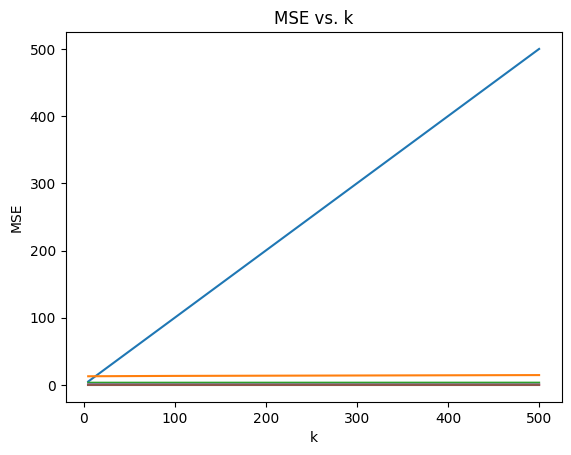

In [47]:
# k값에 따른 시각화
plt.plot(ks, metrics)
plt.xlabel('k')
plt.ylabel('MSE')
plt.title('MSE vs. k')
plt.show()

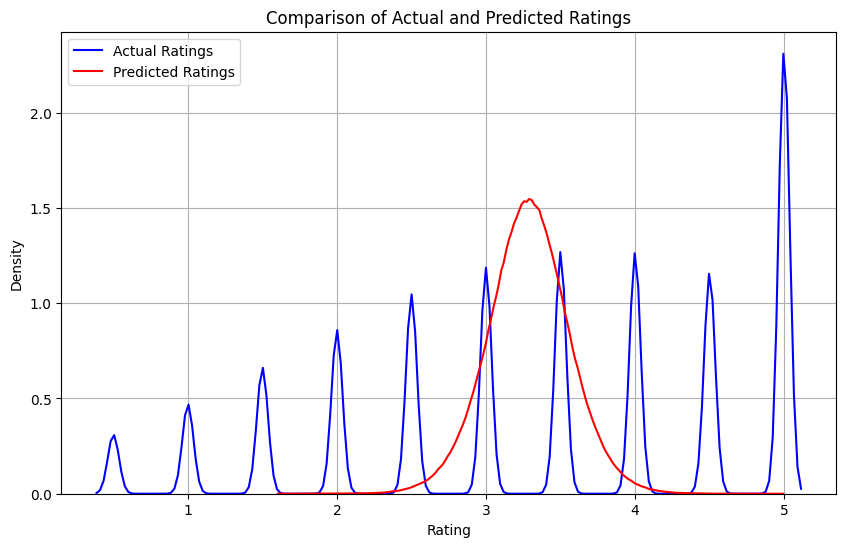

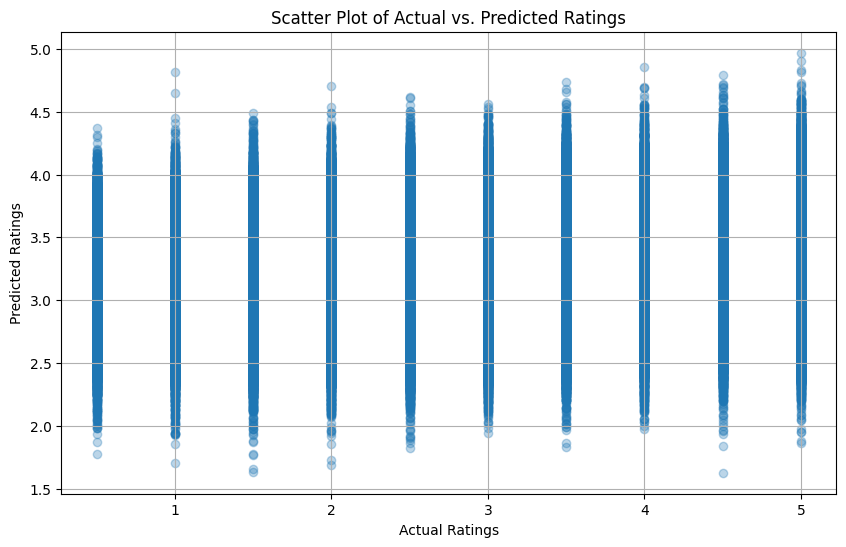

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 데이터에서 평점이 0인 데이터 제외
non_zero_indices = df_user_place_ratings.values.flatten() != 0
actual_ratings = df_user_place_ratings.values.flatten()[non_zero_indices]
predicted_ratings = df_svd_preds.values.flatten()[non_zero_indices]

# 실제 평점과 예측 평점의 분포 비교
plt.figure(figsize=(10, 6))
sns.kdeplot(actual_ratings, bw_adjust=0.5, label='Actual Ratings', color='blue')
sns.kdeplot(predicted_ratings, bw_adjust=0.5, label='Predicted Ratings', color='red')
plt.title('Comparison of Actual and Predicted Ratings')
plt.xlabel('Rating')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

# 실제 평점과 예측 평점의 산점도
plt.figure(figsize=(10, 6))
plt.scatter(actual_ratings, predicted_ratings, alpha=0.3)
plt.title('Scatter Plot of Actual vs. Predicted Ratings')
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.grid(True)
plt.show()


In [49]:
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# 데이터 스케일링
scaler = StandardScaler()
matrix_scaled = scaler.fit_transform(matrix_user_mean)

# k 값에 대한 Grid Search
k_values = [5, 10, 20, 50, 100]
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = []

for k in k_values:
    svd = TruncatedSVD(n_components=k, random_state=42)
    pipeline = make_pipeline(svd)
    score = cross_val_score(pipeline, matrix_scaled, scoring='neg_mean_squared_error', cv=kf)
    scores.append(score.mean())

# 최적의 k 값 출력
best_k = k_values[np.argmax(scores)]
print(f'Best k value: {best_k} with MSE: {max(scores)}')

Best k value: 5 with MSE: nan


Best k value: 5 with MSE: nan 결과는 데이터셋이나 평가 방식에서 문제가 있을 수 있음을 나타냅니다. MSE가 NaN으로 나타나는 것은 보통 다음과 같은 이유 때문일 수 있습니다:

데이터에 NaN 값이 존재: 데이터셋 내에 NaN 값이 포함되어 있어 계산 중에 문제가 발생했을 수 있습니다. 이를 해결하기 위해서는 데이터를 전처리 단계에서 NaN 값을 적절히 처리해야 합니다.


분할된 데이터 셋의 문제: 교차 검증 과정에서 특정 분할이 유효하지 않은 평가를 발생시켰을 수 있습니다. 예를 들어, 특정 분할에서 모든 데이터 포인트가 같은 값으로만 구성되어 있어 분산이 0이 되는 경우 등입니다.


스케일링 문제: 평균이나 표준편차가 0이 되는 경우, StandardScaler가 NaN을 생성할 수 있습니다. 이런 경우에는 스케일링 방법을 재검토하거나 다른 스케일러를 사용하는 것이 좋습니다.

In [50]:
# 이상치에 강하다는 robust스케일러나, 0~1사이로 맞추는 minmax스케일러 NaN을 생성함.
# 0데이터는지우고계산해보자.

평점이 0인 데이터 제외 및 SVD 실행

k=5: Average MSE: 0.0821
k=10: Average MSE: 0.0819
k=20: Average MSE: 0.0814
k=50: Average MSE: 0.0799
k=100: Average MSE: 0.0774
k=200: Average MSE: 0.0724
k=300: Average MSE: 0.0675
k=400: Average MSE: 0.0625
k=500: Average MSE: 0.0575


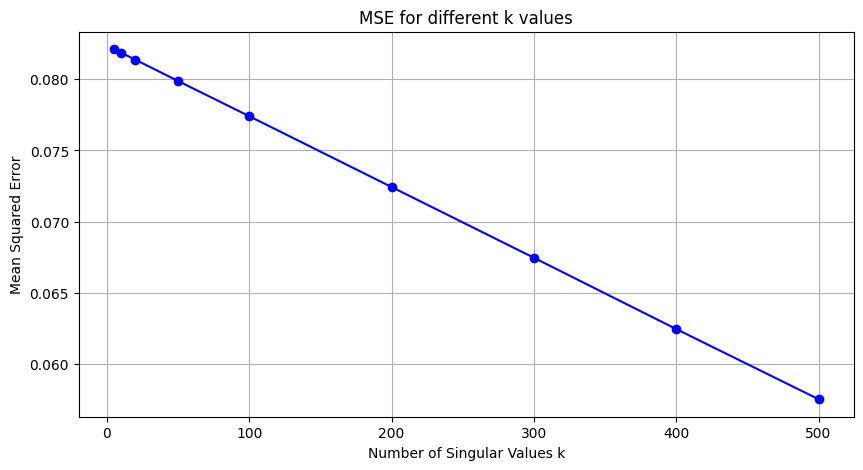

In [51]:
import numpy as np
import pandas as pd
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# 데이터 로드 및 준비
df = pd.read_csv('places.csv', encoding='utf-8')
user_rating = generate_user_ratings(1000)  # 이전에 정의한 사용자 평점 생성 함수 사용

# 평점이 0인 데이터 제외
non_zero_ratings = user_rating[user_rating['rating'] != 0]

# 사용자-장소-평점 피봇 테이블 생성
df_user_place_ratings = non_zero_ratings.pivot_table(index='user_id', columns='place_id', values='rating')

# 데이터 스케일링
scaler = MinMaxScaler()
matrix_scaled = scaler.fit_transform(df_user_place_ratings.fillna(0).values)

# k 값에 대한 교차 검증 설정
k_values = [5, 10, 20, 50, 100,200,300,400,500]
kf = KFold(n_splits=5, shuffle=True, random_state=42)
mse_scores = []

# k 값에 따른 SVD 수행 및 MSE 계산
for k in k_values:
    svd = TruncatedSVD(n_components=k, random_state=42)
    fold_mse_scores = []
    for train_index, test_index in kf.split(matrix_scaled):
        X_train, X_test = matrix_scaled[train_index], matrix_scaled[test_index]

        # SVD 모델 훈련 및 데이터 변환
        svd.fit(X_train)
        X_train_svd = svd.transform(X_train)
        X_test_svd = svd.transform(X_test)

        # 원래 공간으로 데이터 복원
        X_test_svd_reconstructed = svd.inverse_transform(X_test_svd)

        # 평균 제곱 오류 계산
        mse = mean_squared_error(X_test, X_test_svd_reconstructed)
        fold_mse_scores.append(mse)

    average_mse = np.mean(fold_mse_scores)
    mse_scores.append(average_mse)
    print(f'k={k}: Average MSE: {average_mse:.4f}')

# 그래프로 결과 시각화
plt.figure(figsize=(10, 5))
plt.plot(k_values, mse_scores, marker='o', linestyle='-', color='b')
plt.title('MSE for different k values')
plt.xlabel('Number of Singular Values k')
plt.ylabel('Mean Squared Error')
plt.grid(True)
plt.show()


In [52]:
# 최종모델성능 확인
from sklearn.metrics import mean_squared_error

# TruncatedSVD 모델 생성 및 전체 데이터에 대한 훈련
final_k = 300
final_svd = TruncatedSVD(n_components=final_k, random_state=42)
final_svd.fit(matrix_scaled)  # 전체 데이터를 사용하여 SVD 훈련

# 전체 데이터셋을 변환하고 원래 공간으로 복원
X_transformed = final_svd.transform(matrix_scaled)
X_reconstructed = final_svd.inverse_transform(X_transformed)

# 원래 데이터와 재구성된 데이터 사이의 평균 제곱 오차 계산
final_mse = mean_squared_error(matrix_scaled, X_reconstructed)
print(f'Final k={final_k}: MSE={final_mse:.4f}')


Final k=300: MSE=0.0330


In [53]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 데이터를 훈련 세트와 테스트 세트로 분리
X_train, X_test = train_test_split(matrix_scaled, test_size=0.2, random_state=42)

# SVD 모델 훈련
svd = TruncatedSVD(n_components=500, random_state=42)
svd.fit(X_train)

# 훈련 세트와 테스트 세트에서 성능 평가
X_train_reconstructed = svd.inverse_transform(svd.transform(X_train))
X_test_reconstructed = svd.inverse_transform(svd.transform(X_test))
train_mse = mean_squared_error(X_train, X_train_reconstructed)
test_mse = mean_squared_error(X_test, X_test_reconstructed)

print(f'Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}')


Train MSE: 0.0105, Test MSE: 0.0574


In [54]:
# k 값을 줄여서 실험
reduced_k_values = [1000,900,800,700,600,500,300,200,100]  # k 값을 점진적으로 줄여보기
for k in reduced_k_values:
    svd = TruncatedSVD(n_components=k, random_state=42)
    svd.fit(X_train)
    X_train_reconstructed = svd.inverse_transform(svd.transform(X_train))
    X_test_reconstructed = svd.inverse_transform(svd.transform(X_test))
    train_mse = mean_squared_error(X_train, X_train_reconstructed)
    test_mse = mean_squared_error(X_test, X_test_reconstructed)
    print(f'k={k}: Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}')


k=1000: Train MSE: 0.0000, Test MSE: 0.0427
k=900: Train MSE: 0.0000, Test MSE: 0.0427
k=800: Train MSE: 0.0000, Test MSE: 0.0427
k=700: Train MSE: 0.0018, Test MSE: 0.0475
k=600: Train MSE: 0.0053, Test MSE: 0.0525
k=500: Train MSE: 0.0105, Test MSE: 0.0574
k=300: Train MSE: 0.0282, Test MSE: 0.0673
k=200: Train MSE: 0.0417, Test MSE: 0.0723
k=100: Train MSE: 0.0592, Test MSE: 0.0774


값이 0에 수렴할정도로 줄어들긴하지만 train과 test의 차이가 평행하는 문제는 지속된다. 과적합이 의심되므로 train과 test 오차가 만나는 점을 찾아보기로한다.

In [55]:
# k 값을 줄여서 실험
reduced_k_values = [300,200,100,90,80,70,60,50,40,30,20,10]  # k 값을 점진적으로 줄여보기
for k in reduced_k_values:
    svd = TruncatedSVD(n_components=k, random_state=42)
    svd.fit(X_train)
    X_train_reconstructed = svd.inverse_transform(svd.transform(X_train))
    X_test_reconstructed = svd.inverse_transform(svd.transform(X_test))
    train_mse = mean_squared_error(X_train, X_train_reconstructed)
    test_mse = mean_squared_error(X_test, X_test_reconstructed)
    print(f'k={k}: Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}')


k=300: Train MSE: 0.0282, Test MSE: 0.0673
k=200: Train MSE: 0.0417, Test MSE: 0.0723
k=100: Train MSE: 0.0592, Test MSE: 0.0774
k=90: Train MSE: 0.0613, Test MSE: 0.0778
k=80: Train MSE: 0.0633, Test MSE: 0.0783
k=70: Train MSE: 0.0655, Test MSE: 0.0788
k=60: Train MSE: 0.0677, Test MSE: 0.0793
k=50: Train MSE: 0.0699, Test MSE: 0.0798
k=40: Train MSE: 0.0723, Test MSE: 0.0803
k=30: Train MSE: 0.0747, Test MSE: 0.0808
k=20: Train MSE: 0.0772, Test MSE: 0.0813
k=10: Train MSE: 0.0797, Test MSE: 0.0817


k=10: Train MSE: 0.0797, Test MSE: 0.0817
MSE Difference: -0.0020
k=9: Train MSE: 0.0800, Test MSE: 0.0818
MSE Difference: -0.0019
k=8: Train MSE: 0.0802, Test MSE: 0.0819
MSE Difference: -0.0016
k=7: Train MSE: 0.0805, Test MSE: 0.0819
MSE Difference: -0.0014
k=6: Train MSE: 0.0808, Test MSE: 0.0820
MSE Difference: -0.0012
k=5: Train MSE: 0.0810, Test MSE: 0.0820
MSE Difference: -0.0010
k=4: Train MSE: 0.0813, Test MSE: 0.0821
MSE Difference: -0.0008
k=3: Train MSE: 0.0816, Test MSE: 0.0821
MSE Difference: -0.0006
k=2: Train MSE: 0.0818, Test MSE: 0.0822
MSE Difference: -0.0003
k=1: Train MSE: 0.0821, Test MSE: 0.0822
MSE Difference: -0.0001


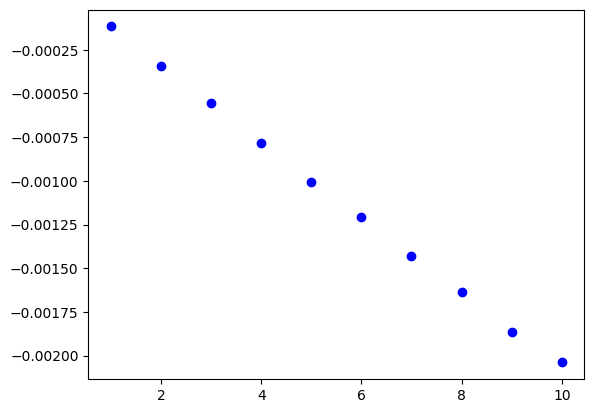

In [56]:
# k 값을 줄여서 실험
reduced_k_values = [10,9,8,7,6,5,4,3,2,1]  # k 값을 점진적으로 줄여보기
for k in reduced_k_values:
    svd = TruncatedSVD(n_components=k, random_state=42)
    svd.fit(X_train)
    X_train_reconstructed = svd.inverse_transform(svd.transform(X_train))
    X_test_reconstructed = svd.inverse_transform(svd.transform(X_test))
    train_mse = mean_squared_error(X_train, X_train_reconstructed)
    test_mse = mean_squared_error(X_test, X_test_reconstructed)
    print(f'k={k}: Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}')
    # Train MSE와 Test MSE의 차이도 계산
    mse_diff = train_mse - test_mse
    print(f'MSE Difference: {mse_diff:.4f}')

    # 시각화
    plt.plot(k, mse_diff, marker='o', linestyle='-', color='b')

k=1: Average MSE (L1): 0.0823
k=2: Average MSE (L1): 0.0823
k=3: Average MSE (L1): 0.0823
k=4: Average MSE (L1): 0.0823
k=5: Average MSE (L1): 0.0823
k=6: Average MSE (L1): 0.0823
k=7: Average MSE (L1): 0.0823
k=8: Average MSE (L1): 0.0823
k=9: Average MSE (L1): 0.0823
k=10: Average MSE (L1): 0.0823
k=11: Average MSE (L1): 0.0823
k=12: Average MSE (L1): 0.0823
k=13: Average MSE (L1): 0.0823
k=14: Average MSE (L1): 0.0823
k=15: Average MSE (L1): 0.0823
k=16: Average MSE (L1): 0.0823
k=17: Average MSE (L1): 0.0823
k=18: Average MSE (L1): 0.0823
k=19: Average MSE (L1): 0.0823
k=20: Average MSE (L1): 0.0823


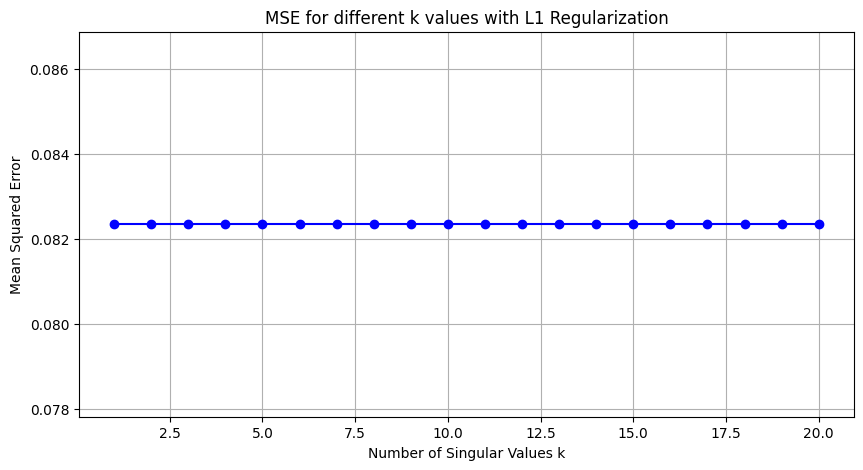

In [57]:
import numpy as np
import pandas as pd
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import ElasticNet
import matplotlib.pyplot as plt

# # 데이터 로드 및 준비
# df = pd.read_csv('places.csv', encoding='utf-8')
# user_rating = generate_user_ratings(1000)  # 이전에 정의한 사용자 평점 생성 함수 사용

# 평점이 0인 데이터 제외
non_zero_ratings = user_rating[user_rating['rating'] != 0]

# 사용자-장소-평점 피봇 테이블 생성
df_user_place_ratings = non_zero_ratings.pivot_table(index='user_id', columns='place_id', values='rating')

# 데이터 스케일링
scaler = MinMaxScaler()
matrix_scaled = scaler.fit_transform(df_user_place_ratings.fillna(0).values)

# k 값에 대한 교차 검증 설정
k_values = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
kf = KFold(n_splits=5, shuffle=True, random_state=42)
mse_scores_l1 = []

# k 값에 따른 SVD 수행 및 MSE 계산
for k in k_values:
    fold_mse_scores_l1 = []
    for train_index, test_index in kf.split(matrix_scaled):
        X_train, X_test = matrix_scaled[train_index], matrix_scaled[test_index]

        # ElasticNet 모델 훈련 및 데이터 변환
        en = ElasticNet(alpha=0.1, l1_ratio=1.0)  # l1_ratio=1.0으로 설정하여 L1 정규화 적용
        y_train = X_train  # 대상 변수는 입력 데이터 그 자체
        en.fit(X_train, y_train)
        X_test_en = en.predict(X_test)

        # 평균 제곱 오류 계산
        mse_l1 = mean_squared_error(X_test, X_test_en)
        fold_mse_scores_l1.append(mse_l1)

    average_mse_l1 = np.mean(fold_mse_scores_l1)
    mse_scores_l1.append(average_mse_l1)
    print(f'k={k}: Average MSE (L1): {average_mse_l1:.4f}')

# 그래프로 결과 시각화
plt.figure(figsize=(10, 5))
plt.plot(k_values, mse_scores_l1, marker='o', linestyle='-', color='b')
plt.title('MSE for different k values with L1 Regularization')
plt.xlabel('Number of Singular Values k')
plt.ylabel('Mean Squared Error')
plt.grid(True)
plt.show()